In [3]:
import pandas as pd
import os

In [4]:
print(os.getcwd())

/Users/takosuzuki/Documents/Untitled Folder


In [1]:
import pandas as pd
data = pd.read_csv(   'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
X = data.drop(columns=['Sales'])
y = data['Sales']

In [2]:
data = pd.read_csv('df.csv')
data.head(5)

,Week,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [104]:
X = data.drop(columns=['sales', 'Week'])
y = data['sales']

In [29]:
# Summary Statistics of the advertising
X.describe()

,TV,radio,newspaper
count,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000
std,85.854236,14.846809,21.778621
min,0.700000,0.000000,0.300000
25%,74.375000,9.975000,12.750000
50%,149.750000,22.900000,25.750000
75%,218.825000,36.525000,45.100000
max,296.400000,49.600000,114.000000


In [17]:
#!pip install pymc3
import theano.tensor as tt

In [105]:
# Saturation & Decay

import theano.tensor as tt

def saturate(x,a):
    return 1 - tt.exp(-a*x)

def carryover(x, strength, length = 25):
    w = tt.as_tensor_variable (
        [tt.power(strength, i) for i in range(length)])
    x_lags = tt.stack(
        [tt.concatenate([tt.zeros(i), x[:x.shape[0]-i]]) for i in range(length)])
    return tt.dot(w, x_lags)

In [19]:
import pymc3 as pm

In [106]:
import pymc3 as pm

with pm.Model() as mmm:
    channel_contributions = []
    
    for channel in X.columns:
        coef = pm.Exponential(f'coef_{channel}', lam=0.0001)
        sat = pm.Exponential(f'sat_{channel}', lam=1)
        car = pm.Beta(f'car_{channel}', alpha=2, beta=2)
        
        channel_data = X[channel].values
        channel_contribution = pm.Deterministic(
            f'contribution_{channel}',
            coef * saturate(
                carryover(
                    channel_data,
                    car
                ),
                sat
            )
        )
        
        channel_contributions.append(channel_contribution)
        
    base = pm.Exponential('base', lam=0.0001)
    noise = pm.Exponential('noise', lam=0.0001)
    
    sales = pm.Normal(
        'sales',
        mu=sum(channel_contributions) + base,
        sigma=noise,
        observed=y
    )
    
    trace = pm.sample(return_inferencedata=True, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, base, car_newspaper, sat_newspaper, coef_newspaper, car_radio, sat_radio, coef_radio, car_TV, sat_TV, coef_TV]


/Users/takosuzuki/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/takosuzuki/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/takosuzuki/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 166 seconds.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The nu

In [39]:
#!pip install arviz
import arviz as az

array([[<AxesSubplot:title={'center':'coef_TV'}>,
        <AxesSubplot:title={'center':'sat_TV'}>,
        <AxesSubplot:title={'center':'car_TV'}>],
       [<AxesSubplot:title={'center':'coef_radio'}>,
        <AxesSubplot:title={'center':'sat_radio'}>,
        <AxesSubplot:title={'center':'car_radio'}>],
       [<AxesSubplot:title={'center':'coef_newspaper'}>,
        <AxesSubplot:title={'center':'sat_newspaper'}>,
        <AxesSubplot:title={'center':'car_newspaper'}>],
       [<AxesSubplot:title={'center':'base'}>,
        <AxesSubplot:title={'center':'noise'}>, <AxesSubplot:>]],
      dtype=object)

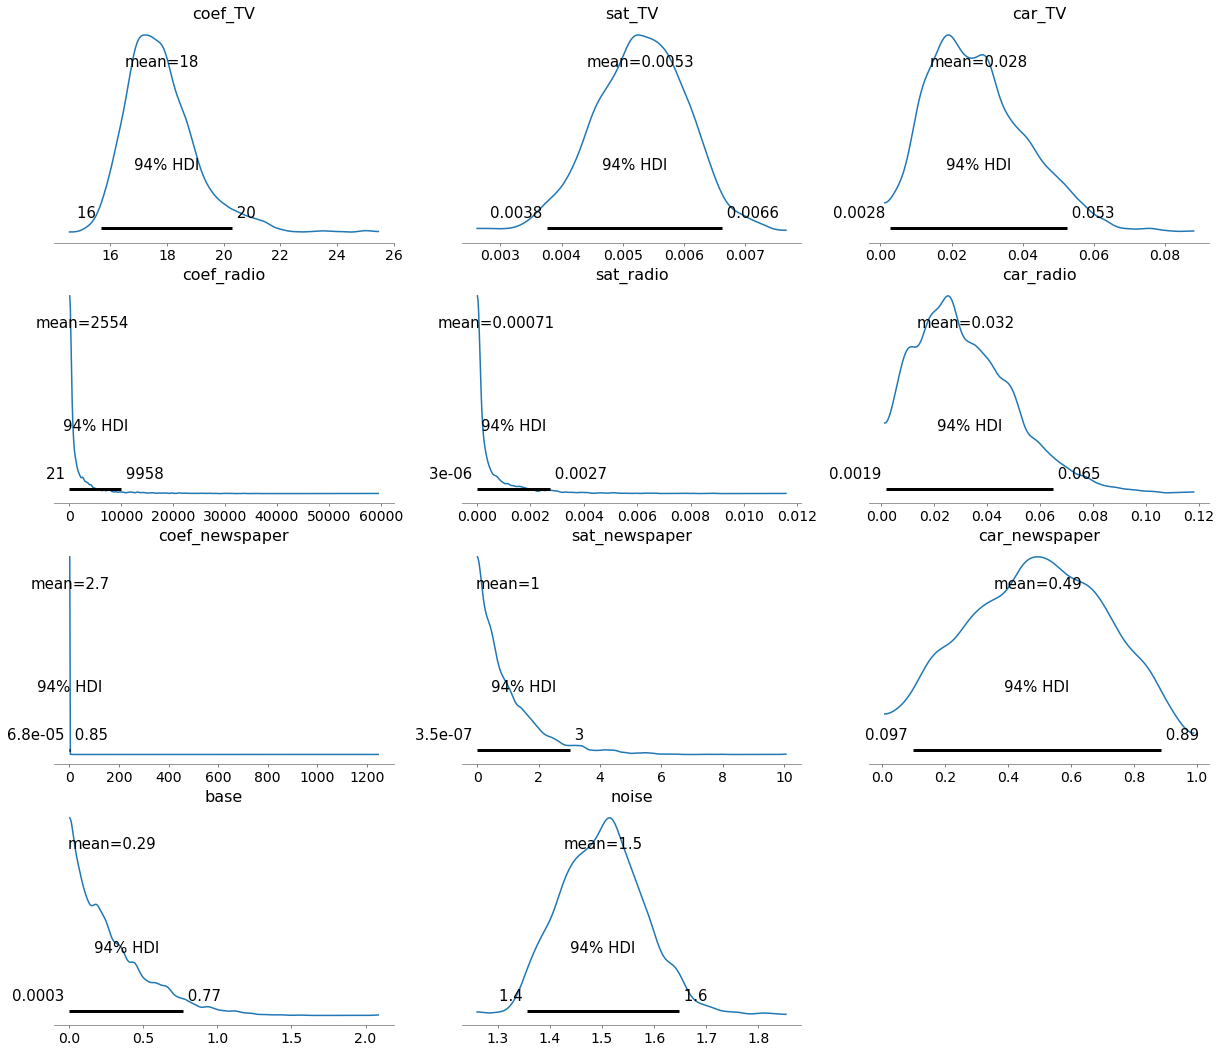

In [107]:
import arviz as az
az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='car_radio', ylabel='sat_radio'>,
        <AxesSubplot:>]], dtype=object)

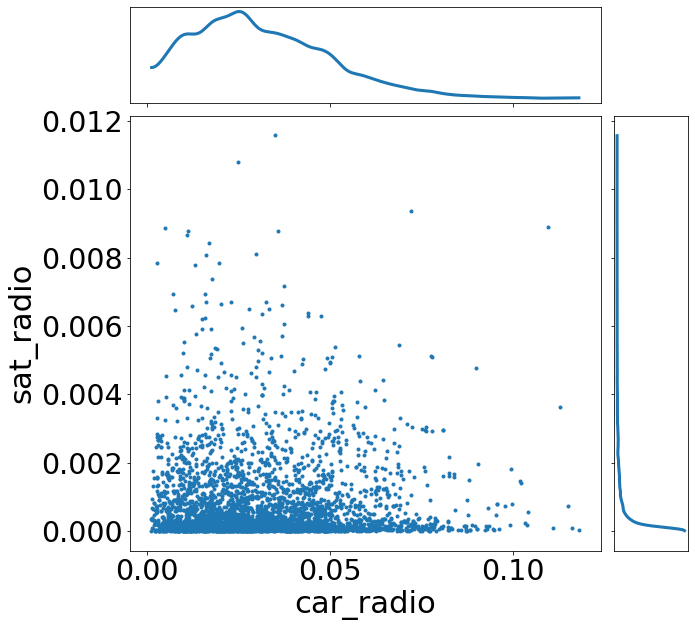

In [115]:
az.plot_pair(
    trace,
    var_names=['car_radio', 'sat_radio'],
marginals=True,
    figsize=(10, 10),)

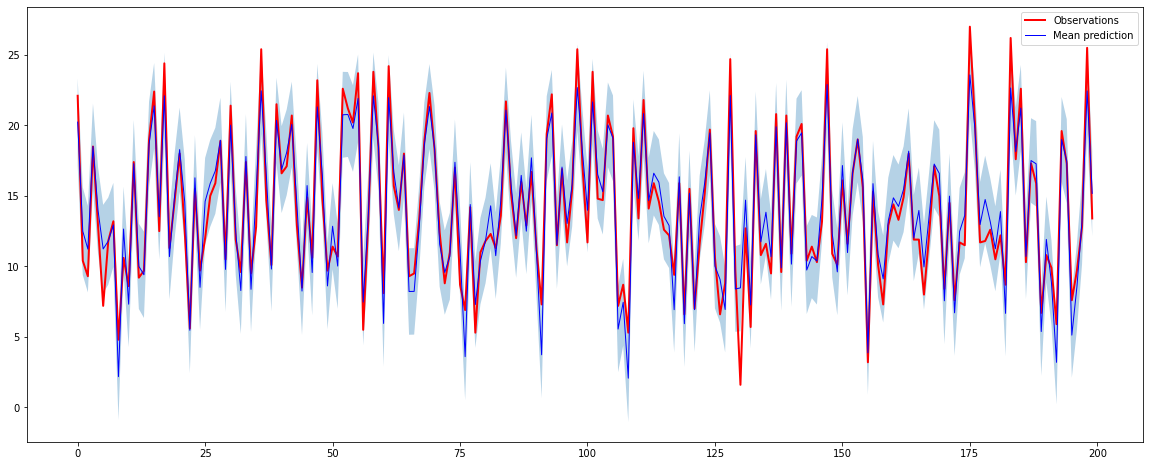

In [116]:
import matplotlib.pyplot as plt
import numpy as np
with mmm:
    posterior = pm.sample_posterior_predictive(trace)
means = posterior['sales'].mean(0)
stds = posterior['sales'].std(0)
plt.figure(figsize=(20, 8))
plt.plot(y.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

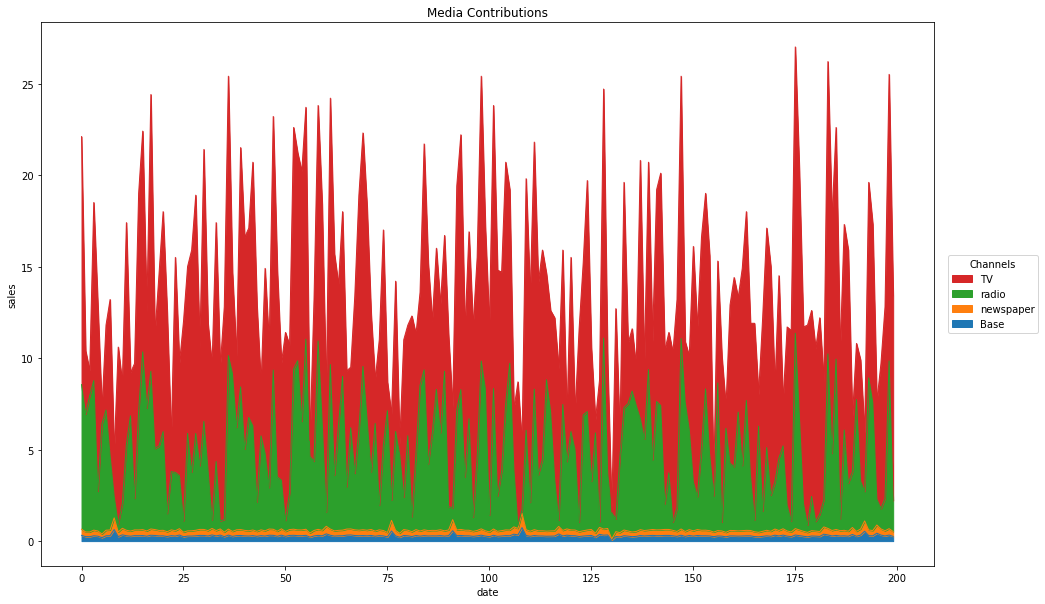

In [119]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'contribution_{channel}']
            .values
            .reshape(4000, 200)
            .mean(0)
           )


channels = ['newspaper', 'radio', 'TV']
unadj_contributions = pd.DataFrame(
    {'Base': trace.posterior['base'].values.mean()},
    index=X.index
)
for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )
ax = (adj_contributions
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Media Contributions',
          ylabel='sales',
          xlabel='date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

In [120]:

channels = ['newspaper', 'radio', 'TV']
unadj_contributions = pd.DataFrame(
    {'Base': trace.posterior['base'].values.mean()},
    index=X.index
)
for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

In [127]:
adj_contributions 
adj_contributions['Week'] = np.arange(len(adj_contributions)+1)

ValueError: Length of values (201) does not match length of index (200)

In [129]:
adj_contributions['Weeks'] = adj_contributions['Week']+1

In [135]:
data2.rename({'Weeks':'Week'}, inplace = True, axis = 1)

In [138]:
df = pd.merge(data,data2, on = 'Week' )

In [139]:
df

,Week,TV_x,radio_x,newspaper_x,sales,Base,newspaper_y,radio_y,TV_y
0,1,230.1,37.8,69.2,22.1,0.316624,0.335454,7.897754,13.550168
1,2,44.5,39.3,45.1,10.4,0.241260,0.255635,6.441818,3.461287
2,3,17.2,45.9,69.3,9.3,0.239508,0.255331,7.435329,1.369832
3,4,151.5,41.3,58.5,18.5,0.289712,0.308694,8.170730,9.730865
4,5,180.8,10.8,58.4,12.9,0.268076,0.285668,2.174145,10.172111
...,...,...,...,...,...,...,...,...,...
195,196,38.2,3.7,13.8,7.6,0.433216,0.446112,1.414239,5.306432
196,197,94.2,4.9,8.1,9.7,0.328751,0.335517,1.112746,7.922985
197,198,177.0,9.3,6.4,12.8,0.280668,0.283533,1.770686,10.465113
198,199,283.6,42.0,66.2,25.5,0.328831,0.349005,9.164728,15.657436


In [140]:
df.to_csv('contri_2.csv')